In [4]:
import os
import clip
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
from tokenizers import Tokenizer
import copy
from typing import Optional, Any, Union, Callable
from torch import Tensor
import math

In [5]:
config = {
    "device":"cuda" if torch.cuda.is_available() else "cpu",
    "trainpath":"/data/dlcv/hw3/hw3_data/p2_data/images/train/",
    "trainjson":"/data/dlcv/hw3/hw3_data/p2_data/train.json",
    "testpath":"/data/dlcv/hw3/hw3_data/p2_data/images/val/",
    "testjson":"/data/dlcv/hw3/hw3_data/p2_data/val.json",
    "captiontokenpath":"/data/dlcv/hw3/hw3_data/caption_tokenizer.json",
    "model_pth":"/data/allen/hw3model/",
    "maxcaptiontokenlen":60,
    "d_model":768,
    "dim_feedforward":512,
    "num_decoder_layers":3,
    "trainbsz":32,
    "testbsz":256,
    "epochs":30,
    "lr":1.e-4
}
if config["device"] == "cuda":
    torch.cuda.set_device(1)
print('Device used :', config["device"])
tokenizer = Tokenizer.from_file(config["captiontokenpath"])
config["numoftoken"] = tokenizer.get_vocab_size()
config["bos_id"] = tokenizer.token_to_id('[BOS]')
config["eos_id"] = tokenizer.token_to_id('[EOS]')
config["pad_id"] = tokenizer.token_to_id('[PAD]')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Device used : cuda


In [6]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

same_seeds(7777)

In [7]:
def imshow(img):
    img = (img + 1) / 2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'model_state_dict': model.state_dict(),
             'optimizer_state_dict' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to {}'.format(checkpoint_path))

def load_checkpoint(checkpoint_path, device='cpu'):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    return checkpoint["model_state_dict"], checkpoint["optimizer_state_dict"]

In [8]:
class DS(Dataset):
    def __init__(self, imgpath, jsonpath=None, transform=None) -> None:
        self.data = [] #(imgpath, imgname, list of caption/None)
        self.id2caption = {}
        self.image2id = {}
        self.transform = transform
        if jsonpath is not None:
            if os.path.exists(jsonpath):
                with open(jsonpath) as f:
                    jsfile = json.load(f)
                for annotation in jsfile["annotations"]:
                    if annotation["image_id"] not in self.id2caption:
                        self.id2caption[annotation["image_id"]] = []
                    self.id2caption[annotation["image_id"]].append(annotation["caption"])
                for img in jsfile["images"]:
                    self.image2id[img["file_name"]] = img["id"]
            else:
                print("Can't open {}".format(jsonpath))
                exit(-1)
        if os.path.exists(imgpath):
            paths = glob.glob(os.path.join(imgpath, "*.jpg"))
            for path in paths:
                imgname = os.path.split(path)[-1]
                if jsonpath is not None:
                    captions = self.id2caption[self.image2id[imgname]]
                    tgt_ys, tgts = [], []
                    for caption in captions:
                        all_token = tokenizer.encode(caption)
                        token_len = len(all_token.ids)
                        token_cutbos = torch.tensor(all_token.ids[1:] + [config["pad_id"]] * (config["maxcaptiontokenlen"] - (token_len - 1)))
                        token_cuteos = torch.tensor(all_token.ids[:-1] + [config["pad_id"]] * (config["maxcaptiontokenlen"] - (token_len - 1)))
                        tgt_ys.append(token_cutbos), tgts.append(token_cuteos)
                else:
                    captions = tgt_ys = tgts = None
                self.data.append((path, imgname, captions, tgt_ys, tgts))
        else:
            print("Can't open {}".format(imgpath))
            exit(-1)
        self.len = len(self.data)

    def __getitem__(self, index):
        imgpath, imgname, captions, tgt_ys, tgts = self.data[index]
        img = Image.open(imgpath)
        if self.transform:
            img = self.transform(img)
        if captions is not None:
            rd = np.random.randint(len(captions))
            caption = None if captions is None else captions[rd]
            tgt_y = None if tgt_ys is None else tgt_ys[rd]
            tgt = None if tgts is None else tgts[rd]
            return img, imgname, caption, tgt_y, tgt
        else:
            return img, imgname

    def __len__(self):
        return self.len

In [9]:
__, preprocess = clip.load('ViT-L/14@336px', config["device"])
train_loader = DataLoader(DS(config["trainpath"], config["trainjson"], preprocess), batch_size=config["trainbsz"], pin_memory=True, shuffle=True, num_workers=3)
test_loader = DataLoader(DS(config["testpath"], config["testjson"], preprocess), batch_size=config["testbsz"], pin_memory=True, shuffle=False, num_workers=3)
visual_loader = DataLoader(DS(imgpath="/data/dlcv/hw3/hw3_data/p3_data/images/", transform=preprocess), pin_memory=True, shuffle=False)

## Transformer Encoder

In [10]:
class MyEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.clip_encoder, __ = clip.load('ViT-L/14@336px', config["device"])
        self.clip_encoder = self.clip_encoder.float()
        #override vit's forward
        vit = self.clip_encoder.visual
        bound_method = vit_forward.__get__(vit, vit.__class__)
        setattr(vit, 'forward', bound_method)
        #Freeze model parameters
        for param in self.clip_encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.clip_encoder.encode_image(x)

def vit_forward(self, x):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        # x = self.ln_post(x[:,1:,:])
        x = x[:,1:,:]
        
        if self.proj is not None:
            x = x @ self.proj
        return x   


## Transformer Decoder
https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html#torch.nn.MultiheadAttention

In [11]:
class MyDecoder(nn.Module):
    def __init__(self, d_model: int = 512, nhead: int = 8, num_decoder_layers: int = 6, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.relu,
                 layer_norm_eps: float = 1e-5, batch_first: bool = True, norm_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout,
                                                    activation, layer_norm_eps, batch_first, norm_first,
                                                    **factory_kwargs)
        decoder_norm = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)
        self._reset_parameters()
        self.d_model = d_model
        self.nhead = nhead
        self.batch_first = batch_first
        self.linear = nn.Linear(d_model, config["numoftoken"])

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None, memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:

        output, atten_weight = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)
        return self.linear(output), atten_weight

    @staticmethod
    def generate_square_subsequent_mask(sz: int, device='cpu') -> Tensor:
        return torch.triu(torch.full((sz, sz), float('-inf'), device=device), diagonal=1)

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
class TransformerDecoder(nn.Module):
    __constants__ = ['norm']

    def __init__(self, decoder_layer, num_layers, norm=None):
        super(TransformerDecoder, self).__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None, tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        output = tgt
        for mod in self.layers:
            output, atten_weight = mod(output, memory, tgt_mask=tgt_mask,
                         memory_mask=memory_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask,
                         memory_key_padding_mask=memory_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output, atten_weight

class TransformerDecoderLayer(nn.Module):
    __constants__ = ['batch_first', 'norm_first']

    def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.relu,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                            **factory_kwargs)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                                 **factory_kwargs)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward, **factory_kwargs)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, **factory_kwargs)

        self.norm_first = norm_first
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm3 = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        # Legacy string support for activation function.
        if isinstance(activation, str):
            self.activation = _get_activation_fn(activation)
        else:
            self.activation = activation

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerDecoderLayer, self).__setstate__(state)

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None, memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None, memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        x = tgt
        if self.norm_first:
            x = x + self._sa_block(self.norm1(x), tgt_mask, tgt_key_padding_mask)
            att_res, att_weight = self._mha_block(self.norm2(x), memory, memory_mask, memory_key_padding_mask)
            x = x + att_res
            x = x + self._ff_block(self.norm3(x))
        else:
            x = self.norm1(x + self._sa_block(x, tgt_mask, tgt_key_padding_mask))
            att_res, att_weight = self._mha_block(x, memory, memory_mask, memory_key_padding_mask)
            x = self.norm2(x + att_res)
            x = self.norm3(x + self._ff_block(x))

        return x, att_weight

    # self-attention block
    def _sa_block(self, x: Tensor,
                  attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]) -> Tensor:
        x = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=False)[0]
        return self.dropout1(x)

    # multihead attention block
    def _mha_block(self, x: Tensor, mem: Tensor,
                   attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]) -> Tensor:
        x, att_weight = self.multihead_attn(x, mem, mem,
                                attn_mask=attn_mask,
                                key_padding_mask=key_padding_mask,
                                need_weights=True)
        return self.dropout2(x), att_weight

    # feed forward block
    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout3(x)

def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

def _get_activation_fn(activation: str) -> Callable[[Tensor], Tensor]:
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError("activation should be relu/gelu, not {}".format(activation))

## Transformer

In [12]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [13]:
class MyTransformer(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = MyEncoder()
        self.word_embedding = nn.Embedding(config["numoftoken"], config["d_model"])
        self.position_encoding = PositionalEncoding(d_model=config["d_model"], dropout=0)
        self.decoder = MyDecoder(d_model=config["d_model"], num_decoder_layers=config["num_decoder_layers"], dim_feedforward=config["dim_feedforward"])

    def forward(self, src, tgt, tgt_mask=None, tgt_key_padding_mask=None):
        encode_features = self.encoder(src) #(bsz, #patch, d_model)
        # print("encode_features {}".format(encode_features.shape))
        after_emb = self.word_embedding(tgt) #(bsz, maxcaptiontokenlen, d_model)
        # print("afer_emb {}".format(after_emb.shape))
        after_enc = self.position_encoding(after_emb) #(bsz, maxcaptiontokenlen, d_model)
        # print("after_enc {}".format(after_enc.shape))
        logit, atten_weight = self.decoder(after_enc, encode_features, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        # print(atten_weight.shape)
        return logit, atten_weight


In [14]:
def get_loss(pred, ans, vocab_size=config["numoftoken"], label_smoothing=0.1, pad=config["pad_id"]):
    # took this "normalizing" from tensor2tensor. We subtract it for
    # readability. This makes no difference on learning.
    confidence = 1.0 - label_smoothing
    low_confidence = (1.0 - confidence) / float(vocab_size - 1)
    normalizing = -(
        confidence * math.log(confidence) + float(vocab_size - 1) *
        low_confidence * math.log(low_confidence + 1e-20))

    one_hot = torch.zeros_like(pred).scatter_(1, ans.unsqueeze(1), 1)
    one_hot = one_hot * confidence + (1 - one_hot) * low_confidence
    log_pred = F.log_softmax(pred, dim=1)
    #print("=========test2=========", log_pred)

    xent = -(one_hot * log_pred).sum(dim=1)
    xent = xent.masked_select(ans != pad)
    loss = (xent - normalizing).mean()
    return loss

# seq2seq model

In [15]:
class seq2seq(nn.Module):
    def __init__(self, modelpath=None) -> None:
        super().__init__()
        self.transformer = MyTransformer()
        self.opt = optim.Adam(self.transformer.parameters(), lr=config["lr"])
        self.scheduler = optim.lr_scheduler.MultiStepLR(self.opt, milestones=[8,12,20], gamma=0.9)
        if modelpath is not None:
            model_stat, opt_stat = load_checkpoint(modelpath)
            self.transformer.load_state_dict(model_stat)
            self.opt.load_state_dict(opt_stat)
            
    def train(self):
        tgt_mask = self.get_tgt_mask(config["maxcaptiontokenlen"]).to(config["device"])
        # criterion = nn.CrossEntropyLoss(ignore_index=config["pad_id"], label_smoothing=0.1)
        criterion = get_loss
        bestloss = torch.inf
        for ep in range(config["epochs"]):
            self.transformer.train()
            trainloss, valloss = 0., 0.
            for train_idx, (img, imgname, caption, tgt_y, tgt) in enumerate(train_loader):
                img, tgt_y, tgt = img.to(config["device"]), tgt_y.to(config["device"]), tgt.to(config["device"])
                tgt_key_padding_mask = self.get_key_padding_mask(tgt).to(config["device"])
                # print("tgt_y {} tgt {} tgt_mask {} tgt_key_mask {}".format(tgt_y.shape, tgt.shape, tgt_mask.shape, tgt_key_padding_mask.shape))
                logit, atten_weight = self.transformer(img, tgt, tgt_mask, tgt_key_padding_mask)
                # print("logit {}".format(logit.shape))
                loss = criterion(logit.contiguous().view(-1, logit.size(-1)), tgt_y.contiguous().view(-1))
                trainloss += loss.item()
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
            self.scheduler.step()
            self.transformer.eval()
            with torch.no_grad():
                for val_idx, (img, imgname, caption, tgt_y, tgt) in enumerate(test_loader):
                    img, tgt_y, tgt = img.to(config["device"]), tgt_y.to(config["device"]), tgt.to(config["device"])
                    tgt_key_padding_mask = self.get_key_padding_mask(tgt).to(config["device"])
                    logit, atten_weight = self.transformer(img, tgt, tgt_mask, tgt_key_padding_mask)
                    loss = criterion(logit.contiguous().view(-1, logit.size(-1)), tgt_y.contiguous().view(-1))
                    valloss += loss.item()
            if valloss < bestloss:
                self.save(ep + 1)
                bestloss = valloss
            print("Epoch[{}/{}] train_loss : {:.5f} val_loss : {:.5f}".format(ep + 1, config["epochs"], trainloss / train_idx, valloss / val_idx))

    def save(self, ep):
        savepath = os.path.join(config["model_pth"], "hw3_2_s.pth")
        save_checkpoint(savepath, self.transformer, self.opt)
        print("Save model ---> {}".format(savepath))

    def att_vis(self):
        model = MyTransformer().to(config["device"])
        modelckp, __ = load_checkpoint("/data/allen/hw3model/hw3_2.pth", device=config["device"])
        model.load_state_dict(modelckp)
        model.eval()
        with torch.no_grad():
            tgt_mask = self.get_tgt_mask(config["maxcaptiontokenlen"]).to(config["device"])
            for idx, (img, imgname) in enumerate(visual_loader):
                img = img.to(config["device"])
                tgt = torch.ones((img.shape[0], config["maxcaptiontokenlen"]), dtype= torch.int32, device=config["device"]) * config["pad_id"]
                tgt[:,0] = config["bos_id"]
                ori_img = np.array(Image.open(os.path.join("/data/dlcv/hw3/hw3_data/p3_data/images/", imgname[0])).resize((336, 336), 3))
                att_list = [('[BOS]', ori_img)]
                for i in range(1, config["maxcaptiontokenlen"]):
                    # print("{}: {}".format(i, tgt))
                    tgt_key_padding_mask = self.get_key_padding_mask(tgt).to(config["device"])
                    logit, atten_weight = model(img, tgt, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
                    predict = logit.argmax(dim=-1)
                    tgt[:,i] = predict[:,i-1]
                    if predict[0, i-1] == config["eos_id"]:
                        word = '[EOS]'
                    else:
                        word = tokenizer.decode([predict[0, i-1]])
                    att_list.append((word, self.draw_atten_map(atten_weight[0, i-1])))
                    if word == '[EOS]':
                        break
                plt.figure(figsize=(4 * 2, math.ceil(len(att_list) / 4) * 2))
                for i, (word, att_img) in enumerate(att_list):
                    plt.subplot(math.ceil(len(att_list) / 4), 4, i + 1)
                    plt.title(word)
                    plt.axis('off')
                    plt.imshow(att_img, cmap="jet")
                    plt.imshow(ori_img, alpha=0.4)
                plt.tight_layout()
                plt.show()
                print("{}/{}".format(idx + 1, len(visual_loader.dataset)))
    
    def draw_atten_map(self, attens):
        attens = attens.cpu()
        patch_sz, width = 14, 24
        img_patchs = []
        for i in range(width):
            row_patchs = []
            for j in range(width):
                atten = torch.ones((1))*attens[i*width+j]
                row_patch = atten.repeat(patch_sz, patch_sz)
                row_patchs.append(row_patch)
            img_patchs.append(torch.cat(row_patchs, dim=1))
        att_img = torch.cat(img_patchs, dim=0)
        return att_img

    def inference(self):
        model = MyTransformer().to(config["device"])
        modelckp, __ = load_checkpoint("/data/allen/hw3model/hw3_2.pth", device=config["device"])
        model.load_state_dict(modelckp)
        model.eval()
        predict_caption = {}
        with torch.no_grad():
            tgt_mask = self.get_tgt_mask(config["maxcaptiontokenlen"]).to(config["device"])
            for idx, (img, imgname) in enumerate(test_loader):
                img = img.to(config["device"])
                tgt = torch.ones((img.shape[0], config["maxcaptiontokenlen"]), dtype= torch.int32, device=config["device"]) * config["pad_id"]
                tgt[:,0] = config["bos_id"]
                alleos = torch.ones((img.shape[0], ), dtype= torch.int8, device=config["device"])
                for i in range(1, config["maxcaptiontokenlen"]):
                    # print("{}: {}".format(i, tgt))
                    tgt_key_padding_mask = self.get_key_padding_mask(tgt).to(config["device"])
                    logit, atten_weight = model(img, tgt, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
                    predict = logit.argmax(dim=-1)
                    tgt[:,i] = predict[:,i-1]
                    #short cut
                    alleos[predict[:,i-1] == config["eos_id"]] = 0
                    # print(predict[:,i], alleos)
                    if torch.sum(alleos) == 0:
                        break
                tgt = tgt.cpu().tolist()
                # print(tgt)
                for i, name in enumerate(imgname):
                    try:
                        first_eos = tgt[i].index(config["eos_id"])
                    except ValueError:
                        first_eos = config["maxcaptiontokenlen"]
                    predict_caption[name.split('.')[0]] = tokenizer.decode(tgt[i][:first_eos])
                print("{}/{}".format(idx + 1, round(len(test_loader.dataset) / config["testbsz"])))

        with open("predict_s.json", 'w') as f:
            json.dump(predict_caption, f)
                        
    def get_tgt_mask(self, sz):
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(sz)
        return tgt_mask < 0

    def get_key_padding_mask(self, tokens):
        key_padding_mask = torch.zeros(tokens.size())
        key_padding_mask[tokens == config["pad_id"]] = -torch.inf
        return key_padding_mask

In [13]:
model = seq2seq()
model = model.to(config["device"])

In [ ]:
model.train()

model saved to /data/allen/hw3model/hw3_2_s.pth
Save model ---> /data/allen/hw3model/hw3_2_s.pth
Epoch[1/30] train_loss : 4.17673 val_loss : 4.14571
model saved to /data/allen/hw3model/hw3_2_s.pth
Save model ---> /data/allen/hw3model/hw3_2_s.pth
Epoch[2/30] train_loss : 3.37793 val_loss : 3.76563
model saved to /data/allen/hw3model/hw3_2_s.pth
Save model ---> /data/allen/hw3model/hw3_2_s.pth
Epoch[3/30] train_loss : 3.06959 val_loss : 3.46336
model saved to /data/allen/hw3model/hw3_2_s.pth
Save model ---> /data/allen/hw3model/hw3_2_s.pth
Epoch[4/30] train_loss : 2.88914 val_loss : 3.31810
model saved to /data/allen/hw3model/hw3_2_s.pth
Save model ---> /data/allen/hw3model/hw3_2_s.pth
Epoch[5/30] train_loss : 2.75682 val_loss : 3.22724
model saved to /data/allen/hw3model/hw3_2_s.pth
Save model ---> /data/allen/hw3model/hw3_2_s.pth
Epoch[6/30] train_loss : 2.64164 val_loss : 3.11630
model saved to /data/allen/hw3model/hw3_2_s.pth
Save model ---> /data/allen/hw3model/hw3_2_s.pth
Epoch[7/3

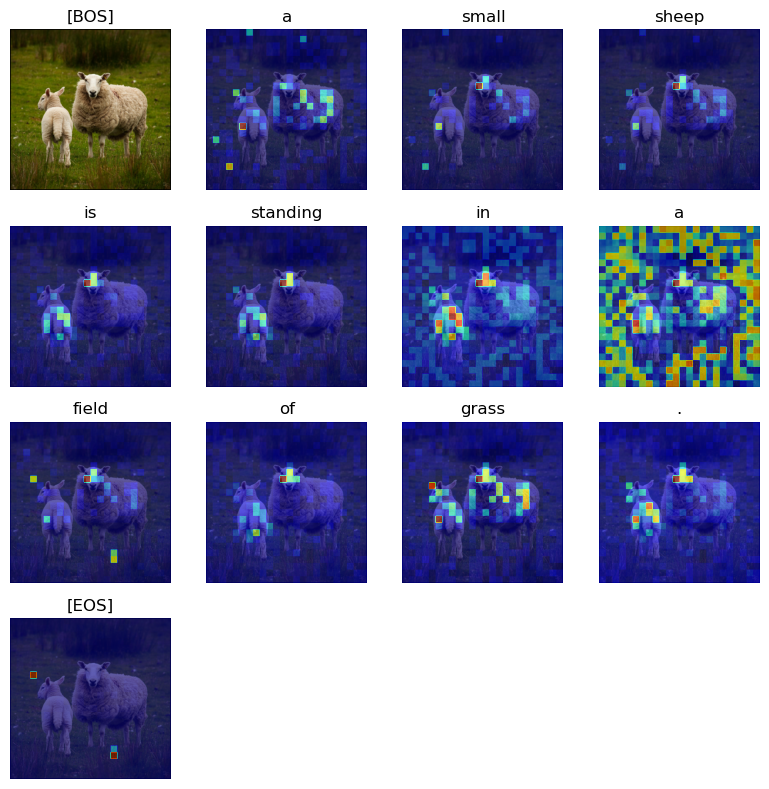

1/5


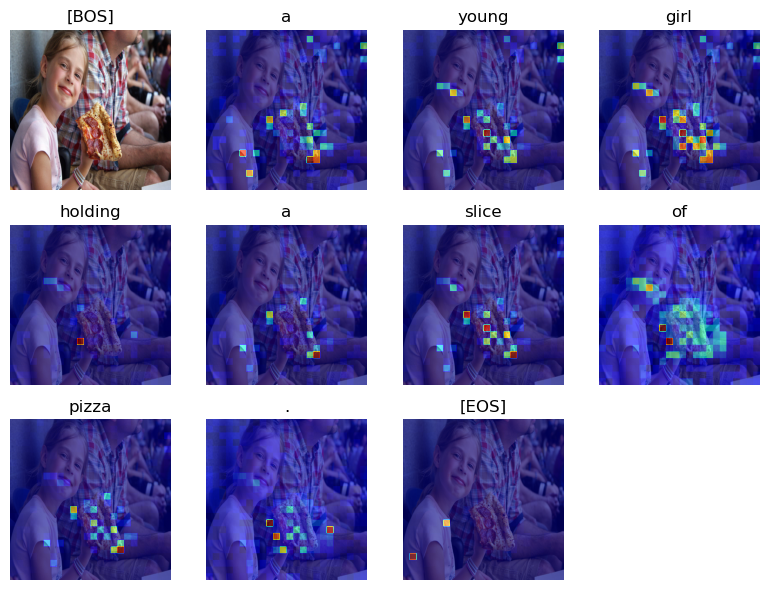

2/5


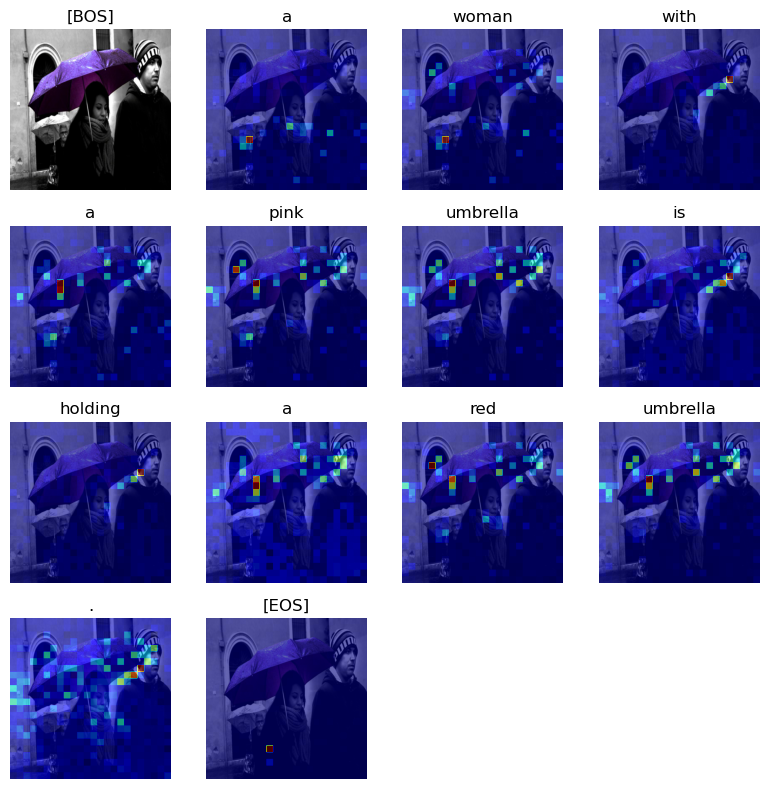

3/5


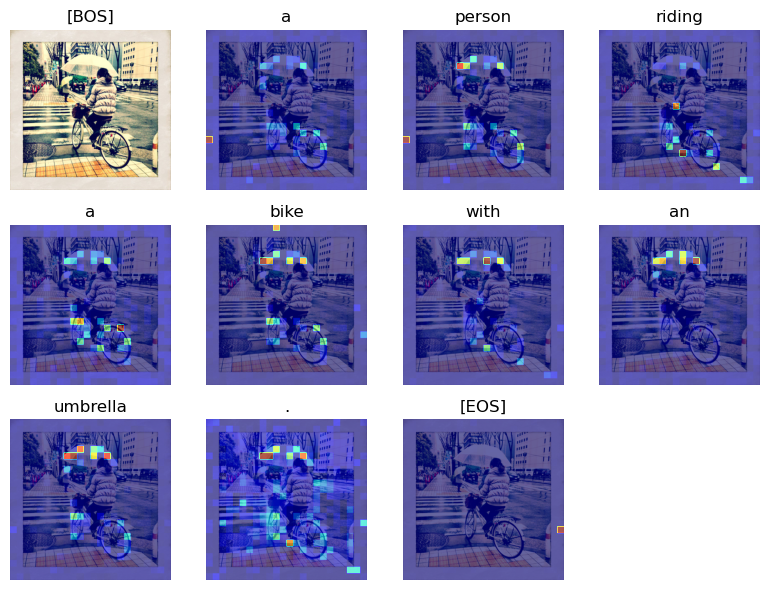

4/5


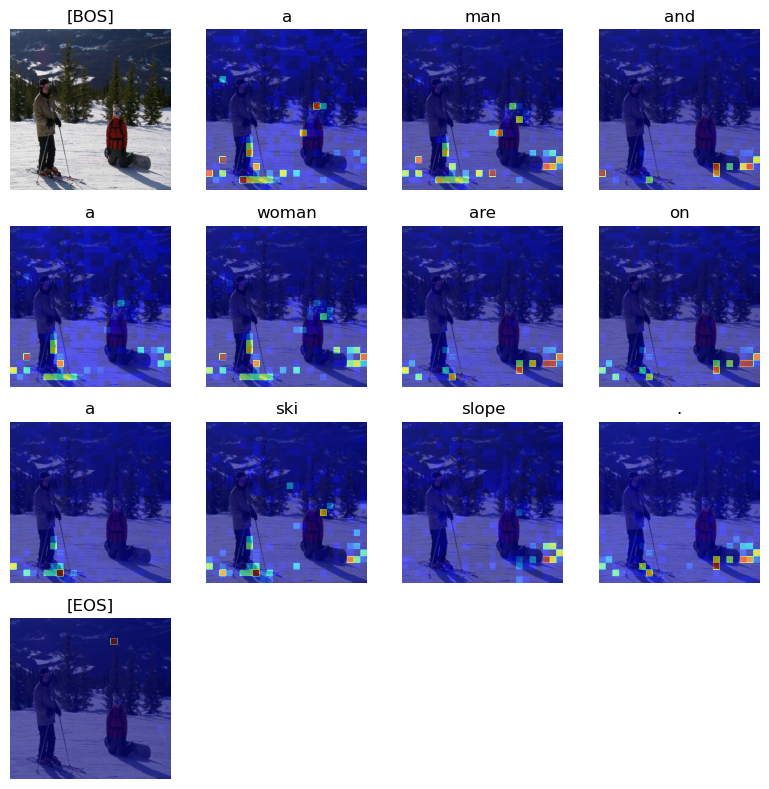

5/5


In [14]:
model.att_vis()

In [3]:
import p2_evaluate as p2

images_root = "/data/dlcv/hw3/hw3_data/p2_data/images/val/"
predictions = p2.readJSON("predict.json")
annotations = p2.readJSON("/data/dlcv/hw3/hw3_data/p2_data/val.json")
clip_score = p2.CLIPScore()
maxclip, maxname = -torch.inf, None
minclip, minname = torch.inf, None

for img_name, pred_caption in predictions.items():
    image_path = os.path.join(images_root, f"{img_name}.jpg")
    image = Image.open(image_path).convert("RGB")
    score = clip_score.getCLIPScore(image, pred_caption)
    if score < minclip:
        minclip = score
        minname = img_name
    if score > maxclip:
        maxclip = score
        maxname = img_name

print(maxclip, maxname, minclip, minname)

0.997314453125 000000179758 0.36895751953125 4927180699


In [16]:
def get_tgt_mask(sz):
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(sz)
    return tgt_mask < 0

def get_key_padding_mask(tokens):
    key_padding_mask = torch.zeros(tokens.size())
    key_padding_mask[tokens == config["pad_id"]] = -torch.inf
    return key_padding_mask
        
def draw_atten_map(attens):
    attens = attens.cpu()
    patch_sz, width = 14, 24
    img_patchs = []
    for i in range(width):
        row_patchs = []
        for j in range(width):
            atten = torch.ones((1))*attens[i*width+j]
            row_patch = atten.repeat(patch_sz, patch_sz)
            row_patchs.append(row_patch)
        img_patchs.append(torch.cat(row_patchs, dim=1))
    att_img = torch.cat(img_patchs, dim=0)
    return att_img

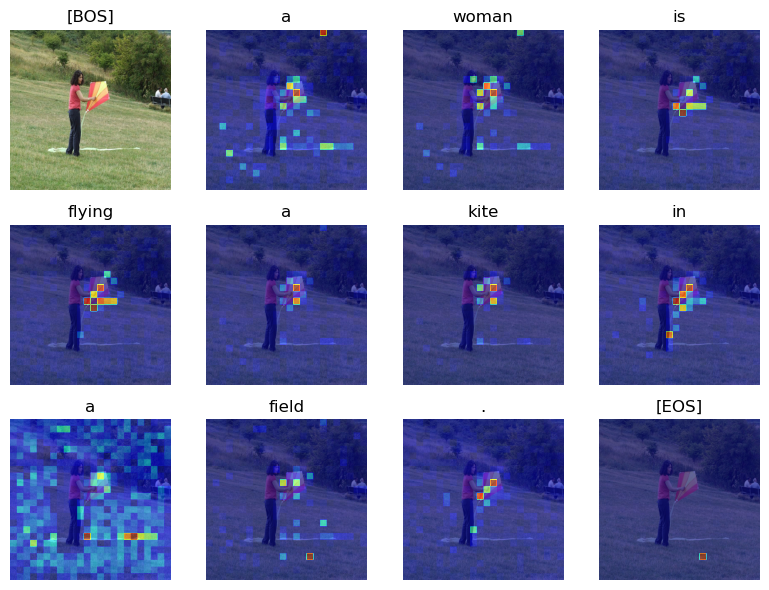

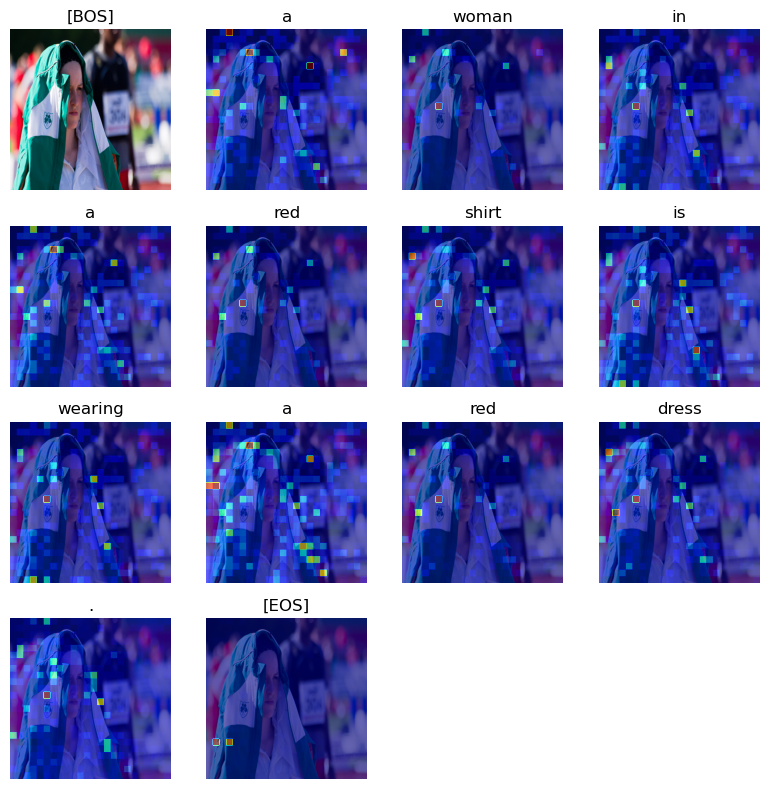

In [20]:
maximg, minimg = preprocess(Image.open(os.path.join(config["testpath"], "000000179758.jpg"))), preprocess(Image.open(os.path.join(config["testpath"], "4927180699.jpg")))
imglist = [(maximg, "000000179758.jpg"), (minimg, "4927180699.jpg")]
model = MyTransformer().to(config["device"])
modelckp, __ = load_checkpoint("/data/allen/hw3model/hw3_2.pth", device=config["device"])
model.load_state_dict(modelckp)
model.eval()
with torch.no_grad():
    tgt_mask = get_tgt_mask(config["maxcaptiontokenlen"]).to(config["device"])
    for idx, (img, imgname) in enumerate(imglist):
        img = img.unsqueeze(0).to(config["device"])
        tgt = torch.ones((img.shape[0], config["maxcaptiontokenlen"]), dtype= torch.int32, device=config["device"]) * config["pad_id"]
        tgt[:,0] = config["bos_id"]
        ori_img = np.array(Image.open(os.path.join(images_root, imgname)).resize((336, 336), 3))
        att_list = [('[BOS]', ori_img)]
        for i in range(1, config["maxcaptiontokenlen"]):
            # print("{}: {}".format(i, tgt))
            tgt_key_padding_mask = get_key_padding_mask(tgt).to(config["device"])
            logit, atten_weight = model(img, tgt, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
            predict = logit.argmax(dim=-1)
            tgt[:,i] = predict[:,i-1]
            if predict[0, i-1] == config["eos_id"]:
                word = '[EOS]'
            else:
                word = tokenizer.decode([predict[0, i-1]])
            att_list.append((word, draw_atten_map(atten_weight[0, i-1])))
            if word == '[EOS]':
                break
        plt.figure(figsize=(4 * 2, math.ceil(len(att_list) / 4) * 2))
        for i, (word, att_img) in enumerate(att_list):
            plt.subplot(math.ceil(len(att_list) / 4), 4, i + 1)
            plt.title(word)
            plt.axis('off')
            plt.imshow(att_img, cmap="jet")
            plt.imshow(ori_img, alpha=0.4)
        plt.tight_layout()
        plt.show()